# Synthesizing Handwritten Digits from the MNIST Dataset using Generative Adversarial Networks (GANs)

This notebook is a _very simple demonstration_ of how Generative Adversarial Networks (GANs) work.  We use the MNIST handwritten digit dataset and a dense MLP-style architecture for both the generator and descriminator along with the [original problem formulation described by Goodfellow, et al](https://arxiv.org/abs/1406.2661).

This example is completely unconditioned.  See my other notebook for a class conditioned example (which performs much better).

In [1]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 11)

In [2]:
import functools
import gzip
import operator
import struct

import tqdm.notebook as tqdm
import munch

import skimage as ski
import matplotlib.pyplot as plt
import numpy as np
import torch as th

## MNIST Dataset

In [3]:
class MNIST(th.utils.data.Dataset):
    '''Simple MNIST dataset.
    '''
    def __init__(self):
        super().__init__()
        self.imgs = self._load_imgs()
        
    @staticmethod
    def _load_imgs():
        '''Load all of the training images.  This dataset is relatively small,
        so we just keep everything in memory on the CPU side.

        Thanks:
            https://stackoverflow.com/questions/39969045/parsing-yann-lecuns-mnist-idx-file-format
        '''
        filename = '../data/torchvision/MNIST/raw/train-images-idx3-ubyte.gz'
        with gzip.open(filename, mode='rb') as fh:
            _magic, size = struct.unpack('>II', fh.read(8))
            nrows, ncols = struct.unpack('>II', fh.read(8))
            data = np.frombuffer(fh.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
            imgs = data.reshape((size, nrows, ncols)) / 255.

        return th.as_tensor(imgs, dtype=th.float32)

    def __getitem__(self, idx):
        '''Return a single image specified by the given index.
        '''
        return self.imgs[idx]
    
    def __len__(self):
        '''Return the number of images in the dataset.
        '''
        return self.imgs.shape[0]
    
    def plot(self, idx):
        '''Plot the image specified by the given index.
        '''
        fig, ax = plt.subplots()
        
        ax.imshow(self.imgs[idx], cmap=plt.cm.gray)
        ax.axis('off')
        
        return munch.Munch(fig=fig, ax=ax)
        
    def plot_montage(self, n=36):
        '''Plot a montage of `n` randomly selected images.
        '''
        idxs = th.randperm(len(self))[:n]
        imgs = self.imgs[idxs]
        
        montage = ski.util.montage(imgs)
        
        fig, ax = plt.subplots()
        ax.imshow(montage, cmap=plt.cm.gray)
        ax.axis('off')
        
        return munch.Munch(fig=fig, ax=ax)

In [4]:
data = MNIST()
len(data)

60000

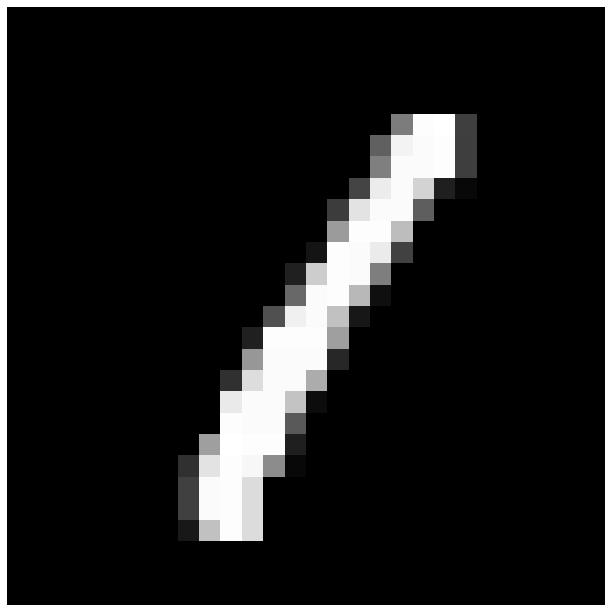

In [5]:
data.plot(3);

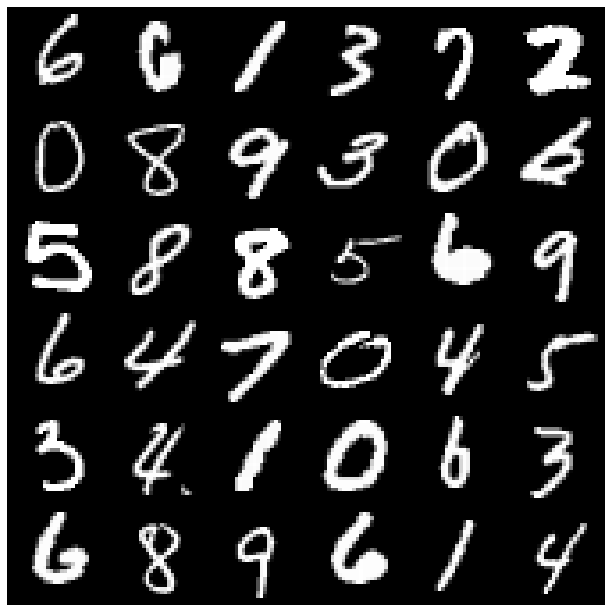

In [6]:
data.plot_montage();

## Generator

We scale our hyperbolic-tangent activation so that it's initially nearly linear and then initialize our linear layers using Kaiming's technique but with a linear activation.  This is an [old trick, described by LeCun, et al,](https://cseweb.ucsd.edu/classes/wi08/cse253/Handouts/lecun-98b.pdf) that seems to work well.

In [7]:
class _Tanh(th.nn.Module):
    '''Hyperbolic tangent, scaled as described in Lecun's backprop tricks paper.
    '''
    def __init__(self):
        super().__init__()
        self.register_buffer('_a', th.as_tensor(1.7159), persistent=False)
        self.register_buffer('_b', th.as_tensor(2. / 3.), persistent=False)

    def forward(self, x):
        return self._a * th.tanh(self._b * x)

In [8]:
class _Linear(th.nn.Linear):
    '''Dense linear layer with linear Kaiming weight initialization.
    '''
    def reset_parameters(self):
        th.nn.init.kaiming_normal_(self.weight, nonlinearity='linear')
        if hasattr(self, 'bias'):
            th.nn.init.zeros_(self.bias)

In [9]:
class Generator(th.nn.Module):
    '''MLP-style generator.
    '''
    def __init__(self, latent_dim=32, img_size=(28, 28), layer_specs=(64, 128, 256)):
        '''Initialize a new generator.
        
        latent_dim (int):
            Expected number of dimensions for the input latent vector
            used for generating images.
        img_size (tuple(int)):
            Two-tuple of integers specifying the height and width of
            the output images in pixels.
        layer_specs (tuple(int)):
            A tuple where each value specifies the number of hidden
            units in each layer.  The number of values in this tuple
            determines the number of layers.
        '''
        super().__init__()
        
        self.latent_dim = latent_dim
        self.img_size = img_size
        
        self.hidden = th.nn.Sequential()
        layer_in, layer_out = None, latent_dim
        for num_units in layer_specs:
            layer_in, layer_out = layer_out, num_units
            self.hidden.append(
                th.nn.Sequential(
                    _Linear(layer_in, layer_out),
                    _Tanh(),
                )
            )

        out_dim = functools.reduce(operator.mul, img_size)
        layer_in, layer_out = layer_out, out_dim
        self.visible = _Linear(layer_in, layer_out)
        
    def forward(self, z):
        '''Forward pass generates synthetic images from
        the latent vector `z`.
        '''
        batch_size, latent_dim = z.shape
        assert latent_dim == self.latent_dim
        
        x = self.visible(self.hidden(z))
        
        return th.sigmoid(x + 0.5).view(batch_size, *self.img_size)
    
    @th.inference_mode()
    def plot_montage(self, n=36, z=None):
        '''Plot a montage of `n` synthetic images.  If `z` is ``None`` then
        the latent vectors will be drawn from the random normal distribution.
        '''
        if z is None:
            z = th.randn(n, self.latent_dim)
        imgs = self(z).cpu()
        
        montage = ski.util.montage(imgs)
        fig, ax = plt.subplots()
        ax.imshow(montage, cmap=plt.cm.gray)
        ax.axis('off')
        
        return munch.Munch(fig=fig, ax=ax)

In [10]:
generator = Generator()
generator

Generator(
  (hidden): Sequential(
    (0): Sequential(
      (0): _Linear(in_features=32, out_features=64, bias=True)
      (1): _Tanh()
    )
    (1): Sequential(
      (0): _Linear(in_features=64, out_features=128, bias=True)
      (1): _Tanh()
    )
    (2): Sequential(
      (0): _Linear(in_features=128, out_features=256, bias=True)
      (1): _Tanh()
    )
  )
  (visible): _Linear(in_features=256, out_features=784, bias=True)
)

In [11]:
sum(p.numel() for p in generator.parameters())

244944

(torch.Size([1, 28, 28]), tensor(0.1532), tensor(0.9141))

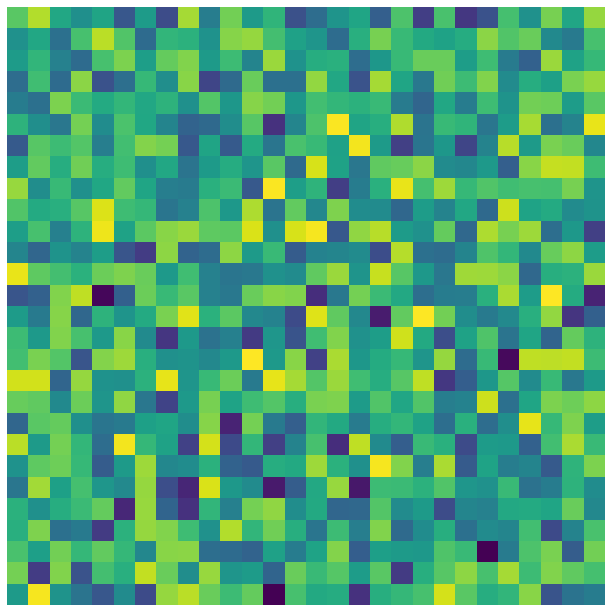

In [12]:
with th.inference_mode():
    im = generator(th.randn(1, generator.latent_dim))

plt.imshow(im[0])
plt.axis('off')
im.shape, im.min(), im.max()

## Discriminator

In [13]:
class Discriminator(th.nn.Module):
    '''MLP-style discriminator.  This is a binary classifier, i.e.,
    there is no class conditioning.  This generator does, however,
    use the mean images for each batch in order to perform a simple
    version of "minibatch discrimination" that helps to prevent
    mode collapse.
    '''
    def __init__(self, img_size=(28, 28), layer_specs=(256, 128, 64)):
        '''Initialize a new discriminator.

        img_size (tuple(int)):
            Two-tuple of integers specifying the height and width of
            the input images in pixels.
        layer_specs (tuple(int)):
            A tuple where each value specifies the number of hidden
            units in each layer.  The number of values in this tuple
            determines the number of layers.
        '''
        super().__init__()

        self.img_size = img_size
        self.in_dim = functools.reduce(operator.mul, img_size)

        self.hidden = th.nn.Sequential()
        layer_in, layer_out = None, self.in_dim * 2
        for num_units in layer_specs:
            layer_in, layer_out = layer_out, num_units
            self.hidden.append(
                th.nn.Sequential(
                    _Linear(layer_in, layer_out),
                    _Tanh(),
                )
            )

        layer_in, layer_out = layer_out, 1
        self.visible = _Linear(layer_in, layer_out)
        
    def forward(self, x):
        '''Forward pass generates predicted class membership
        probabilities for two classes: real and fake.
        '''
        # Means and variances are hard-coded for MNIST
        x = (x - 0.1307) / 0.3081
        
        x = x.flatten(1)
        batch_size, in_dim = x.shape
        assert in_dim == self.in_dim

        # We inject the mean images for each batch.  This is a
        # simplistic form of minibatch discrimination that helps
        # to prevent mode collapse.
        x_mean = x.mean(dim=0, keepdim=True).expand(batch_size, -1)
        x = th.cat((x, x_mean), dim=1)

        return self.visible(self.hidden(x))

In [14]:
discriminator = Discriminator()
discriminator

Discriminator(
  (hidden): Sequential(
    (0): Sequential(
      (0): _Linear(in_features=1568, out_features=256, bias=True)
      (1): _Tanh()
    )
    (1): Sequential(
      (0): _Linear(in_features=256, out_features=128, bias=True)
      (1): _Tanh()
    )
    (2): Sequential(
      (0): _Linear(in_features=128, out_features=64, bias=True)
      (1): _Tanh()
    )
  )
  (visible): _Linear(in_features=64, out_features=1, bias=True)
)

In [15]:
sum(p.numel() for p in discriminator.parameters())

442881

In [16]:
with th.inference_mode():
    logits = discriminator(im)
th.sigmoid(logits)

tensor([[0.6740]])

## Adversarial Training

In [17]:
def train(generator, discriminator, data, epochs=100, batch_size=64, lr=0.001,
          lr_decay=0.98, label_smooth=0.95, device=0):
    generator.to(device)
    discriminator.to(device)

    generator.train()
    discriminator.train()
    
    g_opt = th.optim.RMSprop(generator.parameters(), lr=lr)
    d_opt = th.optim.RMSprop(discriminator.parameters(), lr=lr)
    
    g_sched = th.optim.lr_scheduler.ExponentialLR(g_opt, gamma=lr_decay)
    d_sched = th.optim.lr_scheduler.ExponentialLR(d_opt, gamma=lr_decay)
    
    g_losses, d_losses = [], []
    
    dataloader = th.utils.data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )

    for epoch in tqdm.trange(epochs):
        for i, real_imgs in enumerate(dataloader):
            real_imgs = real_imgs.to(device, non_blocking=True)

            ## Generator
    
            real_targs = th.ones(2 * batch_size, 1, device=device)

            z = th.randn(2 * batch_size, generator.latent_dim, device=device)
            fake_imgs = generator(z)

            g_loss = th.nn.functional.binary_cross_entropy_with_logits(
                discriminator(fake_imgs), real_targs)

            g_losses.append(g_loss.item())

            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()

            ## Discriminator

            fake_targs = th.zeros(batch_size, 1, device=device)
            real_targs = th.ones(batch_size, 1, device=device)

            with th.no_grad():
                z = th.randn(batch_size, generator.latent_dim, device=device)
                fake_imgs = generator(z)

            fake_loss = th.nn.functional.binary_cross_entropy_with_logits(
                discriminator(fake_imgs), fake_targs)
            real_loss = th.nn.functional.binary_cross_entropy_with_logits(
                discriminator(real_imgs), real_targs * label_smooth)  
            d_loss = (fake_loss + real_loss) / 2.

            d_losses.append(d_loss.item())

            d_opt.zero_grad()
            d_loss.backward()            
            d_opt.step()
                
        g_sched.step()
        d_sched.step()
            
    generator.eval()
    discriminator.eval()
    
    generator.cpu()
    discriminator.cpu()
    
    return munch.Munch(
        g_losses=g_losses,
        d_losses=d_losses,
    )

In [18]:
result = train(generator, discriminator, data, epochs=350, batch_size=256, lr=0.001, device=1)

  0%|          | 0/350 [00:00<?, ?it/s]

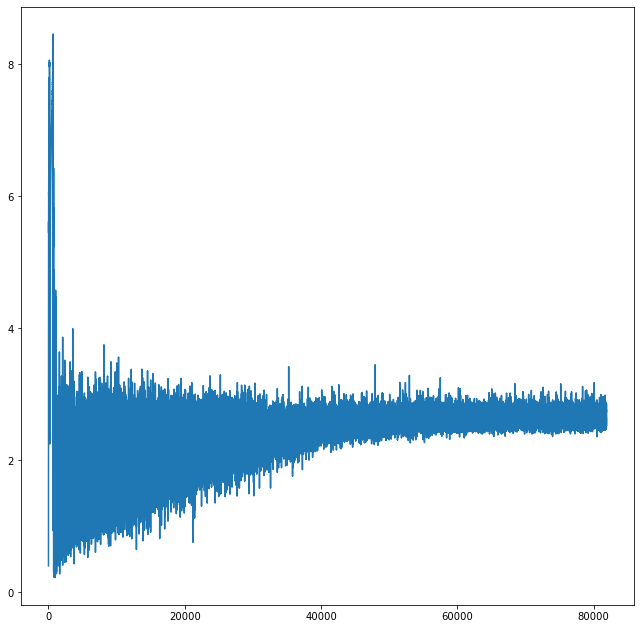

In [19]:
plt.plot(result.g_losses);

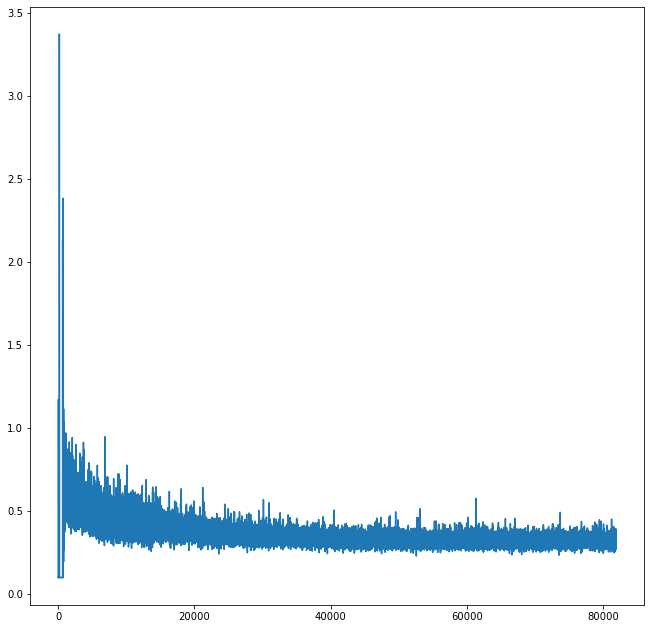

In [20]:
plt.plot(result.d_losses);

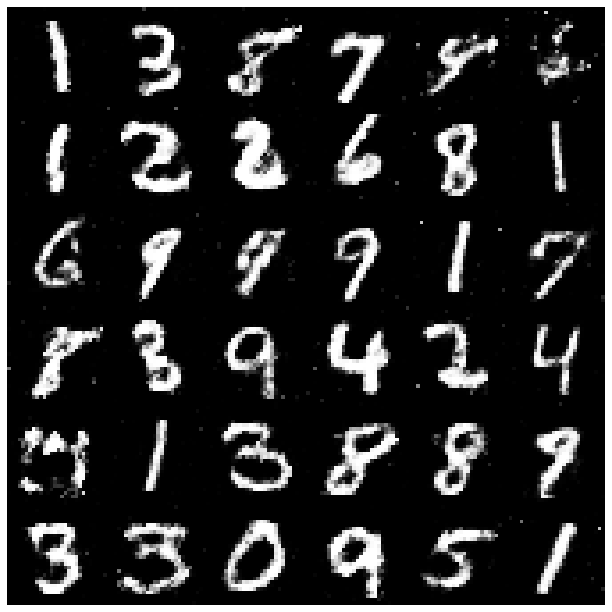

In [21]:
generator.plot_montage();

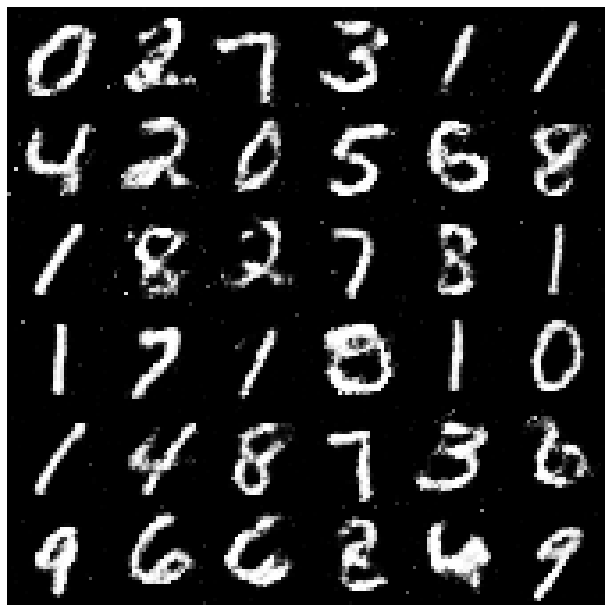

In [22]:
generator.plot_montage();

## Latent-space interpolation

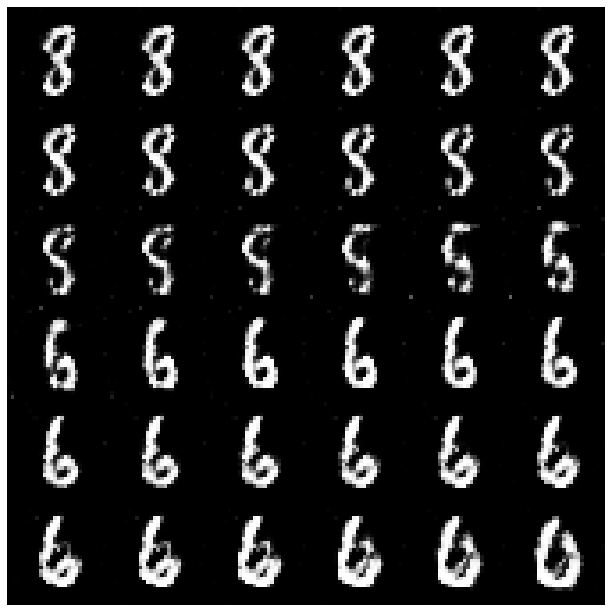

In [23]:
z0 = th.randn(1, generator.latent_dim)
z1 = th.randn(1, generator.latent_dim)

n = 36
alpha = th.linspace(0., 1., n)[:, None]

z = alpha * z0 + (1. - alpha) * z1

generator.plot_montage(n=n, z=z);

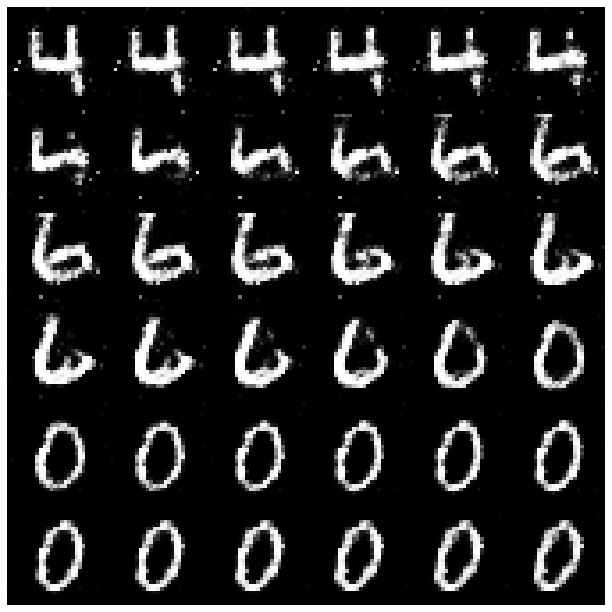

In [24]:
z0 = th.randn(1, generator.latent_dim)
z1 = th.randn(1, generator.latent_dim)

n = 36
alpha = th.linspace(0., 1., n)[:, None]

z = alpha * z0 + (1. - alpha) * z1

generator.plot_montage(n=n, z=z);

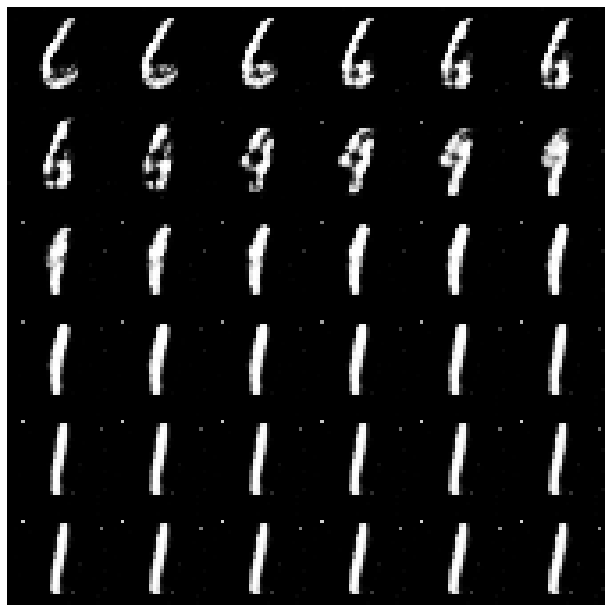

In [25]:
z0 = th.randn(1, generator.latent_dim)
z1 = th.randn(1, generator.latent_dim)

n = 36
alpha = th.linspace(0., 1., n)[:, None]

z = alpha * z0 + (1. - alpha) * z1

generator.plot_montage(n=n, z=z);